<a href="https://colab.research.google.com/github/seraffin/FailOmen/blob/master/Wojtek/NNOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PREPARATIONS:

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
# import keras

# Helper libraries
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataToML_full6.csv to dataToML_full6.csv
User uploaded file "dataToML_full6.csv" with length 499100229 bytes


#**UTILITIES:**

##Optimizer:

In [0]:
#@title

class optimizer:
  """
  -------------------------------
  Function can take 1 or 2 parameters to optimization.
  Default: 2 parameters (you need to set values for minMax1 and minMax2)
           For 1 parameter optimization set argument: "minMax2 = False"

  -------------------------------
  func        -->  enter your function there
                   IMPORTANT:
                   * if function has 1 parameter:  minMax1 = [min, max],   minMax2 = False
                   * if function has 2 parameters: minMax1 = [min1, max1], minMax2 = [min2, max2]
                   
  steps       -->  number of iterations of recurency
  
  minMax1/2   -->  list of min and max value of parameters to begin with (ex. [min, max])
  
  split        -->  number of parts in which function will split values of parameters
                   higher value -> better accuracy & longer calculation time
                   (Values range 2 -- 10)
                   
  reduceSplit -->  If True: with every repetition of recurency will reduce split by one
  
  -------------------------------
  """
  
  import matplotlib.pyplot as plt
  import math
  
  
  
  def __init__(self, func, steps, minMax1, minMax2=False, split = 4, reduceSplit = False, searchMaximum = True):
    self.plotData = []
    self.iterationCounter = 0
    self.iterationsLeft = steps
    self.recurencyCounter = 0
    self.bestResults = []
    
    self.resetIterators()
    self.optimize(func,
                  steps,
                  minMax1,
                  minMax2,
                  split,
                  reduceSplit,
                  searchMaximum = searchMaximum,
                  iLeft = steps+1)
    print(self.bestResults)
    xData = [num[1] for num in self.plotData]
    yData = [num[0] for num in self.plotData]
    self.create_plot_optimizer(xData, yData, 'Iterations', 'Result')
#     return self.bestResults
  
 
  #--------------------

  def returnStepList(self, minValue, maxValue, nrSteps):
      step = math.fabs(maxValue - minValue)/nrSteps
      actualMin = min([minValue, maxValue])
      actualMax = max([minValue, maxValue])
      return [actualMin + step*nr for nr in range(nrSteps + 1)]

  def resetIterators(self):
    self.plotData = []
    self.iterationCounter = 0
    self.recurencyCounter = 0


  def create_plot_optimizer(self, x_data, y_data=0, xLabel = 'X', yLabel = 'Y'):
      import matplotlib.pyplot as plt

      if y_data == 0:  
          unzip = list(zip(*x_data))
          x_data, y_data = unzip[0],unzip[1]
      plt.plot(x_data, y_data)
      plt.xlabel(xLabel)
      plt.ylabel(yLabel)
      plt.show()

  def findBestSolution(self, searchMaximum):
      best = [0]
      for res in self.bestResults:
        if searchMaximum:
          if res[0] >= best[0]:
            best = res
        else:
          if res[0] <= best[0]:
            best = res
      
      
      if len(self.bestResults[0]) == 2:
        print('\n------------------ACHIEVED RESULTS------------------\n')
        print("{:<20}{}\n{:<20}{}\n".format('RESULT: ',
                                            best[0],
                                            'PARAMETER 1: ',
                                            best[1]))
#               return bestResult
      elif len(self.bestResults[0]) == 3:
        print('\n------------------ACHIEVED RESULTS------------------\n')
        print("{:<20}{}\n{:<20}{}\n{:<20}{}\n".format('RESULT: ',
                                                      best[0],
                                                      'PARAMETER 1: ',
                                                      best[1],
                                                      'PARAMETER 2: ',
                                                      best[2]))
      else:
        print("no optimization results record")
        
        
  def optimize(self, func, steps, minMax1, minMax2 = False, split = 4, reduceSplit = False, 
               searchMaximum = True, iLeft = None):
      
      bestResult = []
      
      localICounter = 0
      iL = iLeft
      sMax = searchMaximum
      singleParam = False
      bestPair = [None, None]
      resultList = []
      parametersList=[]

      if reduceSplit is False:
        newSplit = split
      else:
        if split > 2:
          newSplit = split - 1
        else:
          newSplit = 2
      if split > 10:
        raise ValueError("Too big value of 'split' parameter! This would highly increase number of iterations")
      if minMax2 is False:
        singleParam = True

      self.recurencyCounter += 1

      if isinstance(minMax1, list) and (isinstance(minMax2, list) or singleParam) :

          stepList1 = self.returnStepList(minMax1[0], minMax1[1], split)
          if singleParam:
            stepList2 = [1]
          else:
            stepList2 = self.returnStepList(minMax2[0], minMax2[1], split)
          
          nrIterations = len(stepList1)*len(stepList2)
          i1 = 0
          i2 = 0



          for el1 in stepList1:
              i2 = 0
              for el2 in stepList2:
                  self.iterationCounter += 1
                  localICounter += 1
                  print("---Iteration: {0}/{1} ----Recurency: {2}/{3}".format(localICounter, 
                                                              nrIterations,
                                                              self.recurencyCounter,
                                                              iL))

                  #----function----
                  if singleParam:
                    evaluation = func(el1)
                  else:
                    evaluation = func(el1, el2)
                  #----function----

                  if len(resultList) > 0:
                      #----condition----
                      if sMax:
                        if evaluation >= max(resultList):
                            bestPair[0] = i1
                            bestPair[1] = i2
                      else:
                        if evaluation <= min(resultList):
                            bestPair[0] = i1
                            bestPair[1] = i2

                      #----condition----

                  else:
                    if singleParam:
                      bestPair[0] = i1
                    else:
                      bestPair[0] = i1
                      bestPair[1] = i2

                  self.plotData.append([evaluation, self.iterationCounter])

                  resultList.append(evaluation)
                  if singleParam:
                    parametersList.append([el1])
                  else:
                    parametersList.append([el1, el2])

                  i2 += 1
              i1 += 1

          #------------------------------------------------


          if bestPair[0] == stepList1.index(stepList1[0]):
              minMax1[0] = stepList1[bestPair[0]]/2
              minMax1[1] = stepList1[bestPair[0] + 1]
  #                 print("best values of PARAM_1 are close to MIN value")

          elif bestPair[0] == stepList1.index(stepList1[-1]):
              minMax1[0] = stepList1[bestPair[0] - 1]
              minMax1[1] = stepList1[bestPair[0]]*2
  #                 print("best values of PARAM_1 are close to MAX value")


          else:
              minMax1[0] = stepList1[bestPair[0] - 1]
              minMax1[1] = stepList1[bestPair[0] + 1]

          #------------------------------------------------
          if not singleParam:
            if bestPair[1] == stepList2.index(stepList2[0]):
                minMax2[0] = stepList1[bestPair[1]]/2
                minMax2[1] = stepList1[bestPair[1] + 1]
  #                 print("best values of PARAM_2 are close to MIN value")

            elif bestPair[1] == stepList2.index(stepList2[-1]):
                minMax2[0] = stepList1[bestPair[1] - 1]
                minMax2[1] = stepList1[bestPair[1]]*2
  #                 print("best values of PARAM_2 are close to MAX value")


            else:
                minMax2[0] = stepList2[bestPair[1] - 1]
                minMax2[1] = stepList2[bestPair[1] + 1]

          #------------------------------------------------
          if sMax:
            result = max(resultList)
            param1 = parametersList[resultList.index(max(resultList))][0]
            if not singleParam:
              param2 = parametersList[resultList.index(max(resultList))][1]
          else:
            result = min(resultList)
            param1 = parametersList[resultList.index(min(resultList))][0]
            if not singleParam:
              param2 = parametersList[resultList.index(min(resultList))][1]
          
          if singleParam:
            self.bestResults.append([result, param1])
          else:
            self.bestResults.append([result, param1, param2])

          if steps > 0:
            if singleParam:
              print("---------------------------------------------------------\n")
              self.optimize(func,
                           steps - 1,
                           [minMax1[0],minMax1[1]],
                           minMax2 = False,
                           split = newSplit,
                           reduceSplit=reduceSplit,
                           searchMaximum = sMax,
                           iLeft = iL )
            else:
              print("---------------------------------------------------------\n")
              self.optimize(func,
                           steps - 1,
                           [minMax1[0], minMax1[1]],
                           minMax2=[minMax2[0], minMax2[1]],
                           split = newSplit,
                           reduceSplit=reduceSplit,
                           searchMaximum = sMax,
                           iLeft = iL)
            
          else:
            self.findBestSolution(searchMaximum)

      else:
          print("enter correct value!")


###Example:

---Iteration: 1/64 ----Recurency: 1/5
---Iteration: 2/64 ----Recurency: 1/5
---Iteration: 3/64 ----Recurency: 1/5
---Iteration: 4/64 ----Recurency: 1/5
---Iteration: 5/64 ----Recurency: 1/5
---Iteration: 6/64 ----Recurency: 1/5
---Iteration: 7/64 ----Recurency: 1/5
---Iteration: 8/64 ----Recurency: 1/5
---Iteration: 9/64 ----Recurency: 1/5
---Iteration: 10/64 ----Recurency: 1/5
---Iteration: 11/64 ----Recurency: 1/5
---Iteration: 12/64 ----Recurency: 1/5
---Iteration: 13/64 ----Recurency: 1/5
---Iteration: 14/64 ----Recurency: 1/5
---Iteration: 15/64 ----Recurency: 1/5
---Iteration: 16/64 ----Recurency: 1/5
---Iteration: 17/64 ----Recurency: 1/5
---Iteration: 18/64 ----Recurency: 1/5
---Iteration: 19/64 ----Recurency: 1/5
---Iteration: 20/64 ----Recurency: 1/5
---Iteration: 21/64 ----Recurency: 1/5
---Iteration: 22/64 ----Recurency: 1/5
---Iteration: 23/64 ----Recurency: 1/5
---Iteration: 24/64 ----Recurency: 1/5
---Iteration: 25/64 ----Recurency: 1/5
---Iteration: 26/64 ----Recurency:

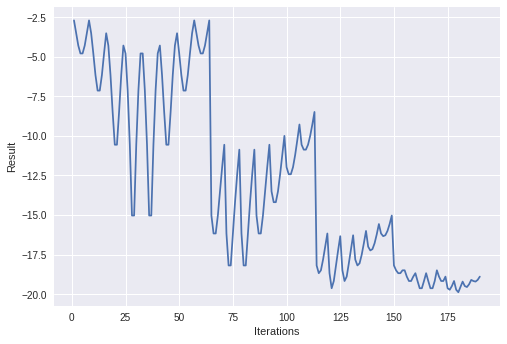

In [0]:
#@title
def exampleFunction(x, y = 5):
  return ((-20)* math.exp((((0.5*(x**2 + y**2))**0.5)*(-0.2))))


r = optimizer(exampleFunction, 4 , [-10,10], minMax2=[-10, 10],  split = 7, reduceSplit = True, searchMaximum = False)
print(r)

In [0]:
print(r)

None


##**Other:**

In [0]:
#@title
def searchForFailed(yList):
    changedRowList = []
    for row in range (len(yList)):
        if 0 in yList[row]:
            changedRowList.append(row)
    return changedRowList

def returnFailedData(xList, yList, changedRowList):
    xFailed = []
    yFailed = []
  
    for row in changedRowList:
        xFailed.append(xList[row])
        yFailed.append(yList[row])
    xFailed = np.array(xFailed)
    yFailed = np.array(yFailed)
    return xFailed, yFailed



In [0]:
#@title
def count_distribution(prediction):
    #Distributions of argmins through all the predictions
    i = 1
    tab = [0] * 542
    for a in prediction:
        j = 0
        for b in a:
            if b < 1.0 : j = j + 1

        #print (i, '. ', j, np.argmin(a))
        tab[np.argmin(a)] += 1
        i = i + 1

    i = 0
    distributed_array = []
    for a in tab:
        if a > 0 : 
            #print ('position', i, '\targmin count', a)
            distributed_array.append((i,a))
        i += 1
    create_plot(distributed_array)  
    return distributed_array


In [0]:
#@title
def failsCount():
    fala = 0
    for i, a in enumerate(yTest):
        j = 0
        for k, b in enumerate(a):
            if b < 1.0 : j += 1

        if j > 0 : 
            print (i, '. ', j)
        i = i + 1
        fala += j
    print (fala)

In [0]:
# @title
# Evaluation function

def evaluation(additionalPredictions, refYsupervisor, predictions, verbose = False):
  
  lenght = len(refYsupervisor)

  failPositions = [[] for y in range(lenght)]

  for i, a in enumerate(refYsupervisor):

    for j, b in enumerate(a):
      if b == 0 : failPositions[i].append(j);

  predictionsTemp = predictions.copy()
  predictionPositions = [[] for y in range(lenght)]


  for i, a in enumerate(predictionsTemp):

    if len(failPositions[i]) != 0:
      for j in range(1 + additionalPredictions):
        argmin = np.argmin(a)
        predictionPositions[i].append(argmin)
        predictionsTemp[i][argmin] = 1

  predictionHits = [[] for y in range(lenght)]

  for i, a in enumerate(failPositions):
    count = 0
    for j, b in enumerate(a):


      for c in predictionPositions[i]:
        if c == b : count += 1

    if len(failPositions) != 0:
      predictionHits[i] = count


  failsCount = 0
  hitsCount = 0
  for i, a in enumerate(refYsupervisor):
    j = 0

    for k, b in enumerate(a):
      if b < 1.0 : j += 1

  #  if j > 0 :
  #    print (i, '.', j, predictionHits[i])


    failsCount += j
    hitsCount += predictionHits[i]
  result = hitsCount / failsCount * 100
  print('Percentage of fails predicted', result, '%')
  
  if verbose == True:
    for i in range(lenght):
      print(i ,len(failPositions[i]), len(predictionPositions[i]), predictionHits[i], sep='\t')
  return result

In [10]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []

  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
    val_targ = self.model.validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict)
    _val_recall = recall_score(val_targ, val_predict)
    _val_precision = precision_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print(" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
    return

metrics = Metrics()

Using TensorFlow backend.


#**NEURAL NETWORK:**

##Data:

In [11]:
#Importing dataset
dataSetName = 'dataToML_full6.csv'

dataset = pd.read_csv(dataSetName, index_col=False)

#Check the first 5 rows of the dataset. 
dataset.head(5)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,1.530,1.531,1.532,1.533,1.534,1.535,1.536,1.537,1.538,1.539
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1


In [0]:
!ls

convertMinidataToML.csv  dataToML_full3.csv  sample_data


In [0]:
x = dataset.iloc[:, 0:23739].values
y = dataset.iloc[:, 23739:24281].values

In [0]:
xReduced, yReduced = returnFailedData(x, y, searchForFailed(y))

In [0]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state=77)

##Model definition:

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.backend.tensorflow_backend import set_session  

import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping


test = False

In [0]:
# One iteration NN

if test:
  from keras.backend.tensorflow_backend import set_session  

  config = tf.ConfigProto()  
  config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
  sess = tf.Session(config=config)  
  set_session(sess)  # set this TensorFlow session as the default session for Keras.

  model = Sequential()


  model.add(Dense(units = 542, activation="sigmoid", input_dim=23739, kernel_initializer="uniform")) # TRY smaller input_dim value or less neurons

  model.compile(optimizer = tf.train.MomentumOptimizer(learning_rate = 0.01, momentum = 0.4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  model.fit(xTrain, yTrain, batch_size = 10, epochs = 2)

  clear_session()

In [0]:
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

def calculateNetwork(x, y):
    inputUnits = 1372
    firstLayerUnits = 10000
    secondLayerUnits = 542
    if not isinstance(inputUnits, (int)) or not isinstance(firstLayerUnits, (int)) or not isinstance(secondLayerUnits, (int)):
        print("Enter correct input!")\

    else:

        config = tf.ConfigProto()  
        config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
        sess = tf.Session(config=config)  
        set_session(sess)
        pBatchSize = 10
        pEpochs = 4
        #best pLearningRate = 0.85
        pLearningRate = 0.25
        #best momentum = 0.1
        pMomentum = 0.25


        model = Sequential()

        # Adding the input layer and the first hidden layer
        model.add(Dense(inputUnits, activation="sigmoid", input_dim=23739, kernel_initializer="uniform")) # TRY smaller input_dim value or less neurons
        # Adding the second hidden layer
        model.add(Dense(firstLayerUnits, activation = "sigmoid", kernel_initializer="uniform"))
        # Adding the output layer
        model.add(Dense(secondLayerUnits, activation="sigmoid", kernel_initializer="uniform"))


        model.compile(optimizer = tf.train.MomentumOptimizer(learning_rate = pLearningRate, momentum = pMomentum), loss = 'binary_crossentropy')
        model.fit(xTrain, yTrain,validation_data=(xTest, yTest), callbacks=[roc_callback(training_data=(xTrain, yTrain),validation_data=(xTest, yTest))], batch_size = pBatchSize, epochs = pEpochs)

        predictions = model.predict(xTest)
        evaluationResult = evaluation(15, yTest, predictions)
        clear_session()
        print('\n')
        return evaluationResult


In [22]:

print(calculateNetwork(0.85, 0.1))


Train on 8208 samples, validate on 2053 samples
Epoch 1/4
8208/8208 [==============================] - 20s 2ms/step - loss: 0.0094 - val_loss: 0.0049


ValueError: ignored

In [0]:
# This commant shows usage of Colab memory
!nvidia-smi

Fri Dec  7 13:22:31 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    56W / 149W |   8334MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

---Iteration: 1/49 ----Recurency: 1/4
Epoch 1/8
1012/1012 [==============================] - 3s 3ms/step - loss: 0.2424 - acc: 0.9558
Epoch 2/8
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0622 - acc: 0.9970
Epoch 3/8
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0393 - acc: 0.9970
Epoch 4/8
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0311 - acc: 0.9970
Epoch 5/8
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0270 - acc: 0.9970
Epoch 6/8
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0246 - acc: 0.9970
Epoch 7/8
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0230 - acc: 0.9970
Epoch 8/8
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0220 - acc: 0.9970
Percentage of fails predicted 29.93027888446215 %


---Iteration: 2/49 ----Recurency: 1/4
Epoch 1/8
1012/1012 [==============================] - 2s 2ms/step - loss: 0.2205 - acc: 0.9609
Epoch 2/

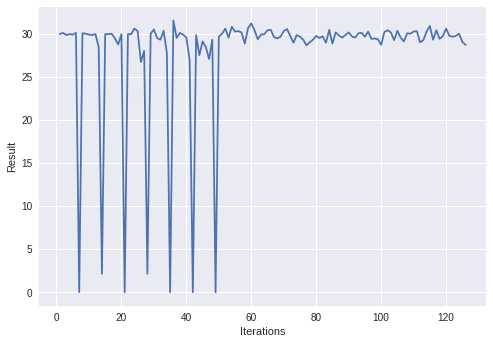

In [0]:
if not test:
  optimizer(calculateNetwork, 3 , [0.1, 1], minMax2=[0.1, 1],  split = 6, reduceSplit = True, searchMaximum = True)
else:
  print("Change 'test' variable to: False")


In [0]:
globalCounter = 0
def calculateNetwork2(parameters):
    global globalCounter
    print("Iteration: {}".format(globalCounter))

    globalCounter += 1
    x = parameters[0]
    y = parameters[1]
    inputUnits = 1372
    firstLayerUnits = 2000
    secondLayerUnits = 542
    if not isinstance(inputUnits, (int)) or not isinstance(firstLayerUnits, (int)) or not isinstance(secondLayerUnits, (int)):
        print("Enter correct input!")\

    else:

        config = tf.ConfigProto()  
        config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
        sess = tf.Session(config=config)  
        set_session(sess)
        pBatchSize = 10
        pEpochs = 2
        #best pLearningRate = 0.85
        pLearningRate = x
        #best momentum = 0.1
        pMomentum = y


        model = Sequential()

        # Adding the input layer and the first hidden layer
        model.add(Dense(inputUnits, activation="sigmoid", input_dim=23739, kernel_initializer="uniform")) # TRY smaller input_dim value or less neurons
        # Adding the second hidden layer
        model.add(Dense(firstLayerUnits, activation = "sigmoid", kernel_initializer="uniform"))
        # Adding the output layer
        model.add(Dense(secondLayerUnits, activation="sigmoid", kernel_initializer="uniform"))


        model.compile(optimizer = tf.train.MomentumOptimizer(learning_rate = pLearningRate, momentum = pMomentum), loss = 'binary_crossentropy', metrics = ['accuracy'])
        model.fit(xTrain, yTrain, batch_size = pBatchSize, epochs = pEpochs)

        predictions = model.predict(xReduced)
        evaluationResult = evaluation(15, yReduced, predictions)
        clear_session()
        print('\n')
        return evaluationResult


In [0]:

import numpy as np
from scipy.optimize import minimize
#optimizer(exampleFunction, 12 , [-10,10], minMax2=[-10, 10],  split = 10, reduceSplit = True, searchMaximum = False)
# x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
x0 = np.array([0.1,0.1])
globalCounter = 0
res = minimize(calculateNetwork2, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
print(res.x) 
 


Iteration: 0
Epoch 1/2
1012/1012 [==============================] - 3s 3ms/step - loss: 0.2375 - acc: 0.9596
Epoch 2/2
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0621 - acc: 0.9970
Percentage of fails predicted 29.63147410358566 %


Iteration: 1
Epoch 1/2
1012/1012 [==============================] - 2s 2ms/step - loss: 0.2342 - acc: 0.9568
Epoch 2/2
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0593 - acc: 0.9970
Percentage of fails predicted 29.133466135458168 %


Iteration: 2
Epoch 1/2
1012/1012 [==============================] - 2s 2ms/step - loss: 0.2406 - acc: 0.9573
Epoch 2/2
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0621 - acc: 0.9970
Percentage of fails predicted 29.183266932270918 %


Iteration: 3
Epoch 1/2
1012/1012 [==============================] - 2s 2ms/step - loss: 0.2349 - acc: 0.9569
Epoch 2/2
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0593 - acc: 0.9970
Percentage of fails pr

KeyboardInterrupt: ignored